### Summary


> 2. Written in tensorflow and executed using Keras Layers.

> 3. Tested on MNIST dataset. 

> 4. 95% test accuracy for 10 epochs.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from utils import check_balance,visualize, creat_datasets, reset_graph, grid_serach, read_pick_file
from layers import  custombn_paper, bn_keras, custom_BLN_Layer, dense_layer
from callbacks import custombn_paper_callback, bn_keras_callbck, custom_BLNLayer_callback, ln_keras_callbck
from callbacks import save_best_model_callback , tensorboard_callback, create_callback_list

In [2]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
tf.__version__

'2.1.0'

### Loading data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
#check_balance(y_train, y_test)

### Visualization

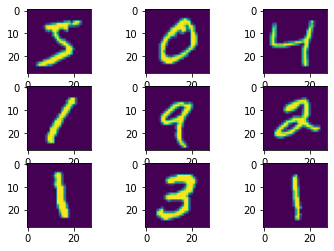

In [6]:
visualize(x_train)

In [7]:
random_seed=100
minibatch = 60
buffersize= 60000
n_of_sampels = 5000
epochs=5
learning_rate = 0.001
number_batches_train = 900 #to train
number_batches_valid = 50 #to valiadation
num_classes = 10

| Model | Batch Number  (* Minibatch)| Loss on Test| Accuracy on Test | Type |
| --------- | --------- | --------- | -------- |--------------------------------------|
| cBLNL | 400 | 0.1809615668790213 |0.9507028 |Bmm:True Bmv:True Fmm:False Fmv:False |
| cBL | 400 | 0.1782991716705532 | 0.95140564 |--- |
| KerasBL | 400 |0.19658853130482407| 0.9439759 |--- |
| KerasLN | 400 | 0.1907331435885056| 0.94799197 |--- |
| --------- | --------- | --------- |----------- |--------------------------------------|
| cBLNL | 900 | 0.1351943160933218 |0.96475905 |Bmm:True Bmv:True Fmm:False Fmv:False |
| cBL | 900 |0.12572812981600592 | 0.9644578 |--- |
| KerasBL | 900 | 0.15859092111104584 | 0.9567269 |--- |
| KerasLN | 900 | 0.14934560496651803 | 0.9613454 |--- |

#### Creating tf.data.Datasets

In [8]:
train_dataset, valid_dataset, test_dataset = creat_datasets(x_train, y_train, x_test, y_test,
                                                            number_of_sampels = n_of_sampels,  random_seed=random_seed,
                                                            minibatch = minibatch, buffersize= buffersize,
                                                            num_classes = num_classes, reshape_to = 28*28 ,
                                                            back_reshape = None)

In [9]:
for i, j in valid_dataset.take(1) :
    print(i.shape, j.shape)

(60, 784) (60, 10)


# 1. Using Custom Batch and Layer Normalization Layer(cBLN)

In [10]:
def custom_BLNLayer_model(inputshape = (784,), units1 = 100, units2 =100, units3=100,
                         classes=10, random_seed=100, batch_size= 60,
                         b_mm = True, b_mv=True, f_mm = False, f_mv=False):
    
    print(b_mm , b_mv, f_mm , f_mv)
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    dense1 = dense_layer(units = units1, name = 'dense1', random_seed=random_seed)(input_lyr)
    custombn1 = custom_BLN_Layer(stateful = True, batchsize= batch_size, name = 'bn1', 
                                  batch_moving_mean=b_mm, batch_moving_var=b_mv,
                                  feature_moving_mean=f_mm, feature_moving_var=f_mv)(dense1) 
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', random_seed=random_seed)(activation1)
    custombn2 = custom_BLN_Layer(stateful = True, batchsize= batch_size, name = 'bn2', 
                                 batch_moving_mean=b_mm, batch_moving_var=b_mv,
                                  feature_moving_mean=f_mm, feature_moving_var=f_mv)(dense2) 
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', random_seed=random_seed)(activation2)
    custombn3 = custom_BLN_Layer(stateful = True, batchsize= batch_size, name = 'bn3', 
                                  batch_moving_mean=b_mm, batch_moving_var=b_mv,
                                  feature_moving_mean=f_mm, feature_moving_var=f_mv)(dense3) 
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [11]:
model_custom_bln_layer = custom_BLNLayer_model(inputshape=(784,),random_seed=random_seed,  batch_size= minibatch)
model_custom_bln_layer.summary()

True True False False
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custom_BLN_Layer)       (None, 100)               723       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custom_BLN_Layer)       (None, 100)               723       
_________________________________________________________________
actv2 (Activation)           (None, 100

# callbacks

In [12]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_custom_BLN_Layer_TTFF_mnist'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
custom_bln_layer_cb = custom_BLNLayer_callback()

custom_bln_layer_cb_list = create_callback_list(save_bm_cb, tb_cb, custom_bln_layer_cb)

In [13]:
model_custom_bln_layer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                               loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                               metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [14]:
model_custom_bln_layer_history =  model_custom_bln_layer.fit(train_dataset.take(number_batches_train), epochs=epochs,
                                                             verbose=1, callbacks=custom_bln_layer_cb_list,
                                                             validation_data=valid_dataset.take(number_batches_valid),
                                                             shuffle=True)

Train for 900 steps, validate for 50 steps
Epoch 1/5
900/900 [==============================] - 33s 37ms/step - loss: 0.2956 - categorical_accuracy: 0.9135 - val_loss: 0.1696 - val_categorical_accuracy: 0.9533
Epoch 2/5
900/900 [==============================] - 32s 36ms/step - loss: 0.1446 - categorical_accuracy: 0.9565 - val_loss: 0.1265 - val_categorical_accuracy: 0.9623
Epoch 3/5
900/900 [==============================] - 32s 36ms/step - loss: 0.0941 - categorical_accuracy: 0.9726 - val_loss: 0.1177 - val_categorical_accuracy: 0.9683
Epoch 4/5
900/900 [==============================] - 33s 37ms/step - loss: 0.0623 - categorical_accuracy: 0.9823 - val_loss: 0.1256 - val_categorical_accuracy: 0.9673
Epoch 5/5
900/900 [==============================] - 33s 37ms/step - loss: 0.0468 - categorical_accuracy: 0.9861 - val_loss: 0.1255 - val_categorical_accuracy: 0.9713


In [15]:
model_custom_bln_layer.evaluate(test_dataset)#[0.19177981183291917, 0.9440763] [0.19284765278718558, 0.94749]

166/166 [==============================] - 2s 11ms/step - loss: 0.1352 - categorical_accuracy: 0.9648


[0.1351943160933218, 0.96475905]

In [16]:
weights_path = "./models/" + folder_name + '/'+ str(number_batches_train) +"_pretrained_weights_TTFF.h5"
model_custom_bln_layer.save_weights(weights_path)

In [17]:
del model_custom_bln_layer, save_bm_cb, tb_cb, custom_bln_layer_cb, custom_bln_layer_cb_list, model_custom_bln_layer_history
reset_graph()

session is clear


In [18]:
save_eval_path = "./logs/" + folder_name + '/'+ str(number_batches_train) +"_sorted_evaluation.pkl"
evaluation = grid_serach(custom_BLNLayer_model, test_dataset,
                         sort=True, save_eval_path = save_eval_path,
                         weights_path =weights_path)

True True True True
166/166 [==============================] - 2s 10ms/step - loss: 0.1437 - categorical_accuracy: 0.9622
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.14374774629502635, 0.962249]}
session is clear
True True True False
166/166 [==============================] - 2s 10ms/step - loss: 0.1423 - categorical_accuracy: 0.9628
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.14374774629502635, 0.962249], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.14233877037438641, 0.96275103]}
session is clear
True True False True
166/166 [==============================] - 2s 10ms/step - loss: 0.1368 - categorical_accuracy: 0.9640
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.14374774629502635, 0.962249], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.14233877037438641, 0.96275103], 'Bmm_True Bmv_True Fmm_False Fmv_True': [0.13676048506609534, 0.9639558]}
session is clear
True True False False
166/166 [==============================] - 2s 10ms/step - loss: 0.1352 - categorical_accuracy: 0.9648
{'Bmm_True Bmv

166/166 [==============================] - 2s 11ms/step - loss: 0.1610 - categorical_accuracy: 0.9558
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.14374774629502635, 0.962249], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.14233877037438641, 0.96275103], 'Bmm_True Bmv_True Fmm_False Fmv_True': [0.13676048506609534, 0.9639558], 'Bmm_True Bmv_True Fmm_False Fmv_False': [0.1351943160933218, 0.96475905], 'Bmm_True Bmv_False Fmm_True Fmv_True': [0.14405230658145687, 0.9623494], 'Bmm_True Bmv_False Fmm_True Fmv_False': [0.1423353056959157, 0.9634538], 'Bmm_True Bmv_False Fmm_False Fmv_True': [0.13709011786275105, 0.9644578], 'Bmm_True Bmv_False Fmm_False Fmv_False': [0.1352359771304932, 0.96506023], 'Bmm_False Bmv_True Fmm_True Fmv_True': [0.16142280071452036, 0.9567269], 'Bmm_False Bmv_True Fmm_True Fmv_False': [0.16100069487618887, 0.9565261], 'Bmm_False Bmv_True Fmm_False Fmv_True': [0.15372869076700993, 0.9587349], 'Bmm_False Bmv_True Fmm_False Fmv_False': [0.153081540865487, 0.9578313], 'Bmm

In [19]:
evaluation

[('Bmm_True Bmv_True Fmm_False Fmv_False', [0.1351943160933218, 0.96475905]),
 ('Bmm_True Bmv_False Fmm_False Fmv_False', [0.1352359771304932, 0.96506023]),
 ('Bmm_True Bmv_True Fmm_False Fmv_True', [0.13676048506609534, 0.9639558]),
 ('Bmm_True Bmv_False Fmm_False Fmv_True', [0.13709011786275105, 0.9644578]),
 ('Bmm_True Bmv_False Fmm_True Fmv_False', [0.1423353056959157, 0.9634538]),
 ('Bmm_True Bmv_True Fmm_True Fmv_False', [0.14233877037438641, 0.96275103]),
 ('Bmm_True Bmv_True Fmm_True Fmv_True', [0.14374774629502635, 0.962249]),
 ('Bmm_True Bmv_False Fmm_True Fmv_True', [0.14405230658145687, 0.9623494]),
 ('Bmm_False Bmv_True Fmm_False Fmv_False', [0.153081540865487, 0.9578313]),
 ('Bmm_False Bmv_False Fmm_False Fmv_False',
  [0.15308500327315766, 0.95843375]),
 ('Bmm_False Bmv_True Fmm_False Fmv_True', [0.15372869076700993, 0.9587349]),
 ('Bmm_False Bmv_False Fmm_False Fmv_True', [0.15402637743278888, 0.9579317]),
 ('Bmm_False Bmv_True Fmm_True Fmv_False', [0.16100069487618887,

# 2. Using the custom Batch Normalization paper (cBNpaper)


In [20]:
# 3 dense layers followed by 3 batch norm layers and a final dense layer with units equal to number of categories
def custom_bnpaper_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10,
                         random_seed=100, batch_size= 60):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = custombn_paper(stateful = True, name = 'bn1', trainable = True, batchsize = batch_size)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = custombn_paper(stateful = True, name = 'bn2', trainable = True, batchsize = batch_size)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = custombn_paper(stateful = True, name='bn3', trainable = True, batchsize = batch_size)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [21]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_custombn_paper_mnist'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
custom_bn_paper_cb = custombn_paper_callback()
### Custom Callbacks
cstm_bn_paper_cb_list = create_callback_list(save_bm_cb, tb_cb, custom_bn_paper_cb)

reset_graph()


session is clear


In [22]:
model_custom_bnpaper = custom_bnpaper_model(inputshape=(784,), random_seed=random_seed, batch_size = minibatch)
model_custom_bnpaper.summary()

# Adam optimizer has adaptive learning rate feature
model_custom_bnpaper.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),\
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_paper)         (None, 100)               402       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_paper)         (None, 100)               402       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [23]:
model_custom_bnpaper_history =  model_custom_bnpaper.fit(train_dataset.take(number_batches_train),
                                                         epochs=epochs, verbose=1, 
                                                        callbacks=cstm_bn_paper_cb_list,
                                                        validation_data=valid_dataset.take(number_batches_valid),
                                                        shuffle=True)

Train for 900 steps, validate for 50 steps
Epoch 1/5
900/900 [==============================] - 18s 20ms/step - loss: 0.3026 - categorical_accuracy: 0.9124 - val_loss: 0.1781 - val_categorical_accuracy: 0.9533
Epoch 2/5
900/900 [==============================] - 18s 20ms/step - loss: 0.1542 - categorical_accuracy: 0.9539 - val_loss: 0.1388 - val_categorical_accuracy: 0.9603
Epoch 3/5
900/900 [==============================] - 18s 20ms/step - loss: 0.1029 - categorical_accuracy: 0.9696 - val_loss: 0.1186 - val_categorical_accuracy: 0.9667
Epoch 4/5
900/900 [==============================] - 18s 20ms/step - loss: 0.0717 - categorical_accuracy: 0.9788 - val_loss: 0.1268 - val_categorical_accuracy: 0.9653
Epoch 5/5
900/900 [==============================] - 18s 20ms/step - loss: 0.0508 - categorical_accuracy: 0.9855 - val_loss: 0.1237 - val_categorical_accuracy: 0.9680


In [24]:
# test dataset
model_custom_bnpaper.evaluate(test_dataset)#

166/166 [==============================] - 1s 7ms/step - loss: 0.1257 - categorical_accuracy: 0.9645


[0.12572812981600592, 0.9644578]

In [25]:
del model_custom_bnpaper, save_bm_cb, tb_cb, cstm_bn_paper_cb_list
reset_graph()

session is clear


# 3.Using the Batch Normal layer implemented in tensorflow

In [26]:
def bn_keras_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = bn_keras(momentum = 0.99, stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = bn_keras(momentum = 0.99, stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = bn_keras(momentum = 0.99, stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [27]:
model_bn_keras = bn_keras_model(inputshape=(784,), random_seed=random_seed)
model_bn_keras.summary()

#### Compiling 
model_bn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (bn_keras)               (None, 100)               401       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (bn_keras)               (None, 100)               401       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [28]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_bn_Keras_mnist'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
bn_keras_cb = bn_keras_callbck()

bn_keras_cb_list = create_callback_list(save_bm_cb, tb_cb, bn_keras_cb)

In [29]:
model_bn_keras_history =  model_bn_keras.fit(train_dataset.take(number_batches_train),
                                             epochs=epochs, verbose=1, 
                                             callbacks=bn_keras_cb_list,
                                             validation_data=valid_dataset.take(number_batches_valid),
                                             shuffle=True)

Train for 900 steps, validate for 50 steps
Epoch 1/5
900/900 [==============================] - 21s 24ms/step - loss: 0.3026 - categorical_accuracy: 0.9124 - val_loss: 0.2141 - val_categorical_accuracy: 0.9390
Epoch 2/5
900/900 [==============================] - 21s 23ms/step - loss: 0.1542 - categorical_accuracy: 0.9539 - val_loss: 0.1662 - val_categorical_accuracy: 0.9520
Epoch 3/5
900/900 [==============================] - 21s 23ms/step - loss: 0.1029 - categorical_accuracy: 0.9696 - val_loss: 0.1451 - val_categorical_accuracy: 0.9593
Epoch 4/5
900/900 [==============================] - 21s 23ms/step - loss: 0.0717 - categorical_accuracy: 0.9788 - val_loss: 0.1580 - val_categorical_accuracy: 0.9547
Epoch 5/5
900/900 [==============================] - 21s 24ms/step - loss: 0.0508 - categorical_accuracy: 0.9855 - val_loss: 0.1565 - val_categorical_accuracy: 0.9583


In [30]:
model_bn_keras.evaluate(test_dataset)#

166/166 [==============================] - 1s 7ms/step - loss: 0.1586 - categorical_accuracy: 0.9567


[0.15859092111104584, 0.9567269]

In [31]:
del model_bn_keras, save_bm_cb, tb_cb, bn_keras_cb_list 
reset_graph()

session is clear


# 4.Using The Layer normalization layer  implemented in tensorflow

In [32]:
def ln_keras_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 =  tf.keras.layers.LayerNormalization()(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 =  tf.keras.layers.LayerNormalization()(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = tf.keras.layers.LayerNormalization()(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [33]:
model_ln_keras = ln_keras_model(inputshape=(784,), random_seed=random_seed)
model_ln_keras.summary()

#### Compiling 
model_ln_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
layer_normalization (LayerNo (None, 100)               200       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [34]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_ln_Keras_mnist'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
ln_keras_cb = ln_keras_callbck()

ln_keras_cb_list = create_callback_list(save_bm_cb, tb_cb, ln_keras_cb)

In [35]:
model_ln_keras_history =  model_ln_keras.fit(train_dataset.take(number_batches_train),
                                             epochs=epochs, verbose=1, 
                                             callbacks=ln_keras_cb_list,
                                             validation_data=valid_dataset.take(number_batches_valid),
                                             shuffle=True)

Train for 900 steps, validate for 50 steps
0
Epoch 1/5
900/900 [==============================] - 16s 18ms/step - loss: 0.2724 - categorical_accuracy: 0.9213 - val_loss: 0.2017 - val_categorical_accuracy: 0.9393
1
Epoch 2/5
900/900 [==============================] - 16s 17ms/step - loss: 0.1331 - categorical_accuracy: 0.9601 - val_loss: 0.1504 - val_categorical_accuracy: 0.9510
2
Epoch 3/5
900/900 [==============================] - 15s 17ms/step - loss: 0.0884 - categorical_accuracy: 0.9745 - val_loss: 0.1433 - val_categorical_accuracy: 0.9560
3
Epoch 4/5
900/900 [==============================] - 15s 17ms/step - loss: 0.0627 - categorical_accuracy: 0.9818 - val_loss: 0.1337 - val_categorical_accuracy: 0.9610
4
Epoch 5/5
900/900 [==============================] - 15s 17ms/step - loss: 0.0463 - categorical_accuracy: 0.9867 - val_loss: 0.1519 - val_categorical_accuracy: 0.9563


In [36]:
model_ln_keras.evaluate(test_dataset)#[0.1779306930860123, 0.95441765]

166/166 [==============================] - 2s 9ms/step - loss: 0.1493 - categorical_accuracy: 0.9613


[0.14934560496651803, 0.9613454]

In [37]:
del model_ln_keras,save_bm_cb, ln_keras_cb, ln_keras_cb_list
reset_graph()

session is clear
